In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
import yfinance as yfin
import scipy
from dateutil.relativedelta import relativedelta
import MH4518.WY.Utils.constants as cs
import MH4518.WY.Utils.Dates as dates 
import MH4518.WY.Utils.payoff as pf
import MH4518.WY.Utils.GBM as gbm
import MH4518.WY.Utils.ProductPrice as pp 

import warnings
warnings.filterwarnings("ignore")
import multiprocessing as mp
import pandas as pd
import logging


%reload_ext autoreload
%autoreload 2


In [2]:
def getdata():
    data = yfin.download(['LONN.SW', 'SIKA.SW'], period= 'max')['Adj Close']
    data.index = data.index.tz_localize(None)
    data = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    return data 

data = getdata()
data = data.dropna()
print(data)

[*********************100%***********************]  2 of 2 completed

Ticker         LONN.SW     SIKA.SW
Date                              
2023-04-27  542.120544  237.429871
2023-04-28  546.263306  242.368103
2023-05-02  545.868835  239.800232
2023-05-03  574.079590  241.479218
2023-05-04  572.895935  242.071823
...                ...         ...
2024-07-24  522.599976  262.000000
2024-07-25  559.799988  258.500000
2024-07-26  581.000000  262.000000
2024-07-29  575.200012  263.700012
2024-07-30  578.799988  269.100006

[316 rows x 2 columns]


In [ ]:
def multi_asset_gbm(data: pd.DataFrame, fdos, nsims: int) -> pd.DataFrame:
    """
    Simulates multiple asset paths under the risk-neutral measure using GBM for multiple simulations.
    """

    try:
        # Prepare the log returns DataFrame
        log_returns_df = pd.DataFrame()
        for ticker in cs.ticker_list:
            log_returns = np.log(data[ticker] / data[ticker].shift(1))
            log_returns_df[ticker] = log_returns
        log_returns_df.dropna(inplace=True)
        
        # compute the covariance matrix of log returns
        cov_matrix = log_returns_df.cov().values 
        vol_vector = np.sqrt(np.diag(cov_matrix))
        corr_matrix = cov_matrix / np.outer(vol_vector, vol_vector)
        L = np.linalg.cholesky(corr_matrix)
        
    except Exception as e:
        print("Error at covariance matrix computation:", e)
        raise
    
    try:
        # Simulation parameters
        date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
        num_steps = len(date_list)  # Number of time steps
        dt = cs.dt  # Time step in years
        
        num_assets = cs.num_ticker  # Number of assets
        
        s0_vector = data.loc[fdos, cs.ticker_list].values  # Initial prices as NumPy array
        
        print(f"Length of date_list: {len(date_list)}")
        print(f"Number of time steps (num_steps): {num_steps}")
        
        # Precompute drift terms
        drift = (cs.interest_rate - 0.5 * vol_vector ** 2) * dt  
        #drift_rnv = (cs.interest_rate) * dt  # risk neutral drift
        
        # Generate random variables
        Z = np.random.normal(size=(num_steps - 1, nsims, num_assets)) 
        Z_reshaped = Z.reshape(-1, num_assets)  
        epsilon = Z_reshaped @ L.T  
        epsilon = epsilon.reshape(num_steps - 1, nsims, num_assets) 
        epsilon = epsilon * np.sqrt(dt)  
        
        # Initialize array to hold simulated prices
        S = np.zeros((num_steps, nsims, num_assets))  
        S[0, :, :] = s0_vector  
        
        # Simulate asset prices
        for t in range(1, num_steps):
            S[t] = S[t - 1] * np.exp(
                drift + vol_vector * epsilon[t - 1]
            )
        
        # Transpose S to shape (num_steps, num_assets, nsims)
        S_transposed = S.transpose(0, 2, 1)  
        
        # Reshape S_transposed to (num_steps, num_assets * nsims)
        S_reshaped = S_transposed.reshape(num_steps, num_assets * nsims)
        
        # Build MultiIndex columns
        assets = cs.ticker_list
        simulations = [f'sim{n+1}' for n in range(nsims)]
        arrays = [[], []]
        for asset in assets:
            for sim in simulations:
                arrays[0].append(asset)
                arrays[1].append(sim)
        tuples = list(zip(*arrays))
        index = pd.MultiIndex.from_tuples(tuples, names=['Asset', 'Simulation'])
        
        # Create DataFrame
        sim_data = pd.DataFrame(S_reshaped, index=date_list)
        sim_data.columns = index
        
    except Exception as e:
        print("Error during simulation:", e)
        raise
        
    return sim_data

def multi_asset_gbm_n_sims(plot: bool, plotasset: bool, nsims: int, data: pd.DataFrame, fdos) -> pd.DataFrame:
    """
    Simulate multiple asset paths under the GBM model for 'nsims' simulations starting from 'fdos'.

    Params:
        plot (bool): Whether to plot the combined simulations.
        plotasset (bool): Whether to plot the simulations for each asset separately.
        nsims (int): Number of simulations to run.
        data (pd.DataFrame): Historical data for assets.
        fdos: First date of simulation.

    Returns:
        sim_data: DataFrame containing simulated asset prices for all simulations.
                  Columns are MultiIndex with levels ('Asset', 'Simulation')
    """

    # Get the list of dates for the simulation period
    date_list = dates.get_list_dates(fdos, cs.final_fixing_date)
    
    # Realized price 
    realised_price = data.loc[cs.initial_fixing_date: cs.final_fixing_date]
    
    try:
        sim_data = multi_asset_gbm(data, fdos, nsims)
        sim_data.index = date_list
        
    except Exception as e:
        raise Exception("Error during simulation") from e

    if plot:
        fig, ax = plt.subplots(figsize=(12, 6))
        # Plot the realized prices
        realised_price.plot(ax=ax, linewidth=2)
        # Plot the simulated paths
        for asset in cs.ticker_list:
            asset_columns = sim_data[asset]
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
        plt.title('Simulated Paths with Realized Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.grid(True)
        plt.show()

    if plotasset:
        for asset in cs.ticker_list:
            asset_columns = sim_data[asset]
            realised_price_asset = realised_price[asset] 

            # Plot asset paths and realized price
            fig, ax = plt.subplots(figsize=(12, 6))
            asset_columns.plot(ax=ax, alpha=0.4, legend=False)
            realised_price_asset.plot(ax=ax, color='black', linewidth=2, label=f'Realized Price {asset}')
            ax.legend()
            plt.title(f'{asset} Paths under Multi Asset GBM')
            plt.xlabel('Date')
            plt.ylabel('Price')
            plt.grid(True)
            plt.show()
            
    return sim_data



In [ ]:
def payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset='Lonza', direction=0):
    """
    Calculates the payoff for each simulation based on the product conditions with perturbations.
    
    Params:
        paths1: DataFrame of simulated paths for Lonza (columns: simulations)
        paths2: DataFrame of simulated paths for Sika (columns: simulations)
        params: Dictionary containing product parameters
        fdos: First date of simulation (pricing date)
        h: Perturbation factor
        perturb_asset: The asset to perturb ('Lonza' or 'Sika')
        direction: Perturbation direction (-1 for down, 1 for up, 0 for base)
    
    Returns:
        payoffs: Array of payoffs for each simulation
    """
    
    
    perturbed_paths1 = paths1.copy()
    perturbed_paths2 = paths2.copy()
    
    # Apply perturbation
    if perturb_asset == 'Lonza':
        perturbed_paths1 = paths1 * (1 + direction * h)
    elif perturb_asset == 'Sika':
        perturbed_paths2 = paths2 * (1 + direction * h)
    else:
        raise ValueError("perturb_asset must be 'Lonza' or 'Sika'")
    
    
    payoffs = pf.payoff(perturbed_paths1, perturbed_paths2, params, fdos)
    return payoffs
def delta(price_arr, S0, h):
    return (price_arr[1] - price_arr[2]) / (2 * h * S0)

def gamma(price_arr, S0, h):
    return (price_arr[1] - 2 * price_arr[0] + price_arr[2]) / (S0 * (h ** 2))


def calculate_greeks(paths1, paths2, params, fdos, h, perturb_asset='Lonza'):
    
    if perturb_asset == 'Lonza':
        S0 = paths1.iloc[0, 0]  
    elif perturb_asset == 'Sika':
        S0 = paths2.iloc[0, 0]
    else:
        raise ValueError("perturb_asset must be 'Lonza' or 'Sika'")
    
    P_base = pf.payoff(paths1, paths2, params, fdos)
    P_up = payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset, direction=1)
    P_down = payoff_perturbed(paths1, paths2, params, fdos, h, perturb_asset, direction=-1)
    
    deltas = delta([P_base, P_up, P_down], S0, h)
    
    
    return deltas

def calculate_greeks_multi_asset(paths1, paths2, params, fdos, h, perturb_assets=['Lonza', 'Sika']):
    greeks_dict = {}
    for asset in perturb_assets:
        deltas, gammas = calculate_greeks(paths1, paths2, params, fdos, h, perturb_asset=asset)
        greeks_dict[asset] = {'Delta': deltas, 'Gamma': gammas}
    return greeks_dict

# Simulation Parameters
h = 0.02  # 2%
perturb_assets = ['Lonza', 'Sika']
params = {
    'Settlement_Delay': 2, 
    'Denomination': 1000,  
    'Coupon_Rate': 0.08/4  
}   

# Risk Managemgent, Constructing Delta Neutral Portfolio 

In [ ]:
date_list = dates.get_list_dates(cs.initial_fixing_date, cs.final_fixing_date)

if isinstance(date_list[0], str):
    date_list = pd.to_datetime(date_list)

productprice_df = pp.product_price()
r = cs.interest_rate
portfolio_value_list = []
date_list = pd.Series(date_list).tolist()

date_list = date_list[-120:]  

params_product = {
    'Denomination': 1000,
    'Coupon_Rate': 0.08 / 4,  #
}

# Collection of Deltas 
mean_delta_lonza_list = []
mean_delta_sika_list = []

# Iterate over each date to calculate portfolio values
for fdos in date_list:
    try:
        # Calculate discount factor based on business days 
        T_discount = dates.num_business_days(fdos, cs.final_fixing_date) / 252  

        np.random.seed(42)
        
        sim_T = multi_asset_gbm_n_sims(
            plot=False,
            plotasset=False,
            nsims=1000,
            data=data,
            fdos=fdos
        )
        

        lonza_path = sim_T['LONN.SW']
        sika_path = sim_T['SIKA.SW']
        
        # Calculate greeks (delta) for each asset
        delta_lonza = calculate_greeks(lonza_path, sika_path, params, fdos, h, perturb_asset= 'Lonza')
        delta_sika = calculate_greeks(lonza_path, sika_path, params, fdos, h, perturb_asset= 'Sika')
        print(delta_lonza)
        print(delta_sika)

        
        # Calculate discounted mean deltas as holdings
        mean_delta_lonza = np.exp(-r * T_discount) * np.mean(delta_lonza)
        print(mean_delta_lonza)
        mean_delta_lonza_list.append(mean_delta_lonza)
        print(mean_delta_lonza_list)
        mean_delta_sika = np.exp(-r * T_discount) * np.mean(delta_sika)
        mean_delta_sika_list.append(mean_delta_sika)
        
        # Retrieve product price for the current date
        product_price = productprice_df.loc[fdos]
        
        # Retrieve realized asset prices 
        S1_realized = data.loc[fdos, 'LONN.SW']  
        S2_realized = data.loc[fdos, 'SIKA.SW']  
        # Check for zero values in critical variables
        if (mean_delta_lonza == 0) or (mean_delta_sika == 0) or (S1_realized == 0) or (S2_realized == 0):
            print(f"Zero value detected on date {fdos.date()}: "
                            f"mean_delta_lonza={mean_delta_lonza}, "
                            f"mean_delta_sika={mean_delta_sika}, "
                            f"S1_realized={S1_realized}, "
                            f"S2_realized={S2_realized}")
        
        # Calculate portfolio value: θ = P - δ1 * S1 - δ2 * S2
        portfolio_value = product_price - (mean_delta_lonza * S1_realized) - (mean_delta_sika * S2_realized)
        print(portfolio_value)
        portfolio_value_list.append(portfolio_value)
    
    except Exception as e:
        
        print(f"Error processing date {fdos}: {e}")
        portfolio_value_list.append(np.nan)

# Convert the list of portfolio values into a DataFrame indexed by date
portfolio_values_df = pd.DataFrame({
    'Portfolio_Value': portfolio_value_list
}, index=date_list)

portfolio_values_df.dropna(inplace=True)  

print(portfolio_values_df.head())




Length of date_list: 120
Number of time steps (num_steps): 120
[1.85479515 1.79885166 1.85909156 1.85055661 1.84028651 1.80145841
 1.88545564 1.82756684 1.82875133 1.85844451]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.8248173040315971
[np.float64(1.8248173040315971)]
Zero value detected on date 2024-02-07: mean_delta_lonza=1.8248173040315971, mean_delta_sika=0.0, S1_realized=433.1818542480469, S2_realized=236.93605041503906
96.45225657567084
Length of date_list: 119
Number of time steps (num_steps): 119
[1.83251255 1.77516029 1.86019689 1.85772031 1.84068423 1.82236483
 1.81322661 1.81532505 1.83919717 1.80900112]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.8110791214313626
[np.float64(1.8248173040315971), np.float64(1.8110791214313626)]
Zero value detected on date 2024-02-08: mean_delta_lonza=1.8110791214313626, mean_delta_sika=0.0, S1_realized=441.71649169921875, S2_realized=235.55335998535156
98.8264842916351
Length of date_list: 118
Number of time steps (num_steps): 118
[1.87392044 1.83671846 1.8511

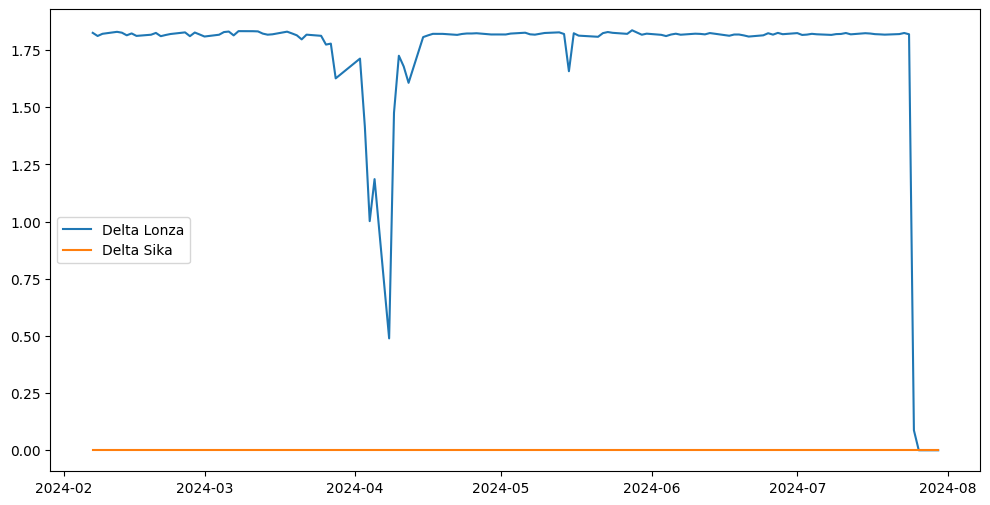

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(date_list, mean_delta_lonza_list, label = 'Delta Lonza')
plt.plot(date_list, mean_delta_sika_list, label = 'Delta Sika')
plt.legend()
plt.show()

<Axes: xlabel='Date'>

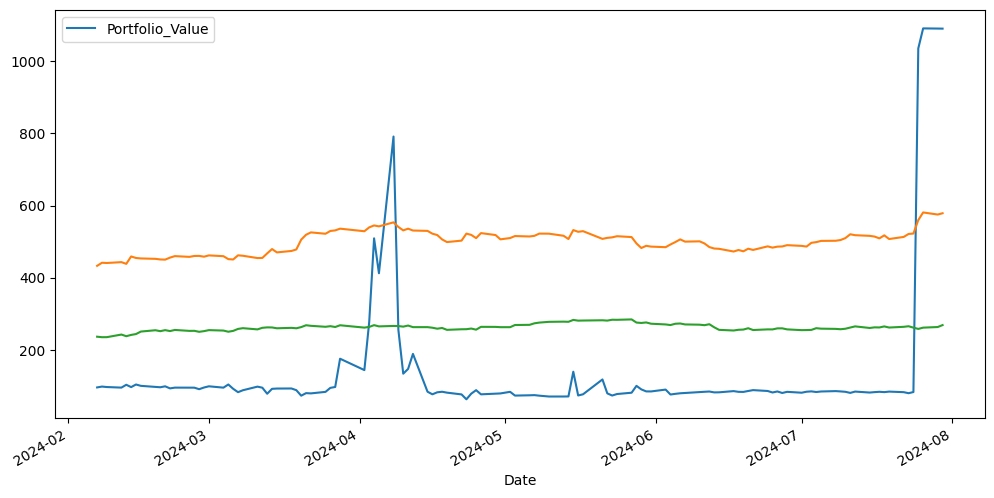

In [38]:
fig, ax = plt.subplots(figsize=(12, 6))
portfolio_values_df.plot(ax = ax)
data.iloc[-120:, 0].plot(ax = ax)
data.iloc[-120:, 1].plot(ax = ax)